In [2]:
import numpy as np
from scipy.stats import chisquare, norm,poisson

import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['Simhei']  #显示中文
plt.rcParams['axes.unicode_minus']=False    #显示负号 

import os
path='figs/' #创建图片文件
os.makedirs(path,exist_ok=True)

# $\chi^2$-test

In [3]:
# A example for good chi square test
f_exp = np.array([44, 50, 52, 38])
f_obs = np.array([43,52,54,40])

f_exp = f_exp/f_exp.sum()*f_obs.sum()
abs(f_exp.sum() - f_obs.sum())<1e-6
print(chisquare(f_obs,f_exp))

Power_divergenceResult(statistic=0.14510098089045517, pvalue=0.9859233956543701)


$\chi^2$ 过检验，统计量很小，p值很大。p值的含义是假设成立（零假设：观测符合预测）的情况下，观测者发生的可能性。p值很大，代表当前观测很有可能发生，无法拒绝零假设。

In [4]:
# A bad example for chi square test
f_exp = np.array([3, 9, 88, 3]) 
f_obs = np.array([43,52,54,40])

f_exp = f_exp/f_exp.sum()*f_obs.sum()
abs(f_exp.sum() - f_obs.sum())<1e-6
print(chisquare(f_obs,f_exp))

Power_divergenceResult(statistic=619.33063438619, pvalue=6.49624492301387e-134)


$\chi^2$ 不过检验，统计量很大，p值很小，代表当前观测很不太可能发生，拒绝零假设。

# 读取数据

In [5]:
df=pd.read_excel('Exp1.xlsx')
df

,放射计数,本底计数
0,243,6
1,239,7
2,253,9
3,273,4
4,241,2
...,...,...
295,242,4
296,225,10
297,238,4
298,257,6


In [6]:
N_t=df['放射计数'].values
N_b=df['本底计数'].values

In [7]:
print(f'放射性计数的平均值为{N_t.mean():.2f}，样本方差为{np.var(N_t,ddof=1):.2f}')
print(f'放射性计数的平均值为{N_b.mean():.2f}，样本方差为{np.var(N_b,ddof=1):.2f}')

放射性计数的平均值为243.43，样本方差为263.03
放射性计数的平均值为5.06，样本方差为5.26


In [8]:
def get_bins(data,center,interval): 
    # get ingerval of {...,center-interval,center,center+interval,...}
    data_max = max(data)
    data_min = min(data)
    if interval>data_max-data_min+1:
        return 'Too small interval'
    while(center<=data_min):
        center+=interval
    while(center>=data_max):
        center-=interval
    bins = [center,]
    point = center-interval
    while(point>data_min):
        bins.insert(0,point)
        point-=interval
    bins.insert(0,point)

    point = center+interval
    while(point<data_max):
        bins.append(point)
        point+=interval
    bins.append(point)
    return bins

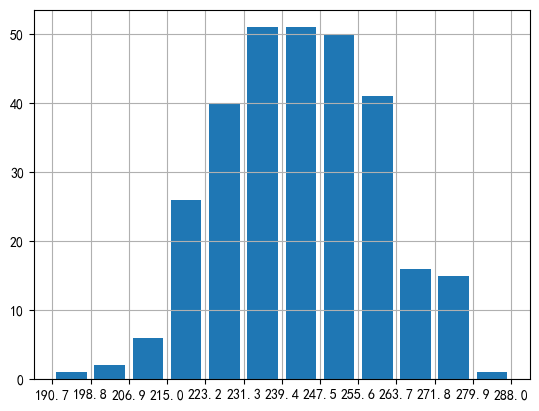

In [9]:
ave_t = N_t.mean()
std_t = N_t.std(ddof = 1)

bins_t = get_bins(N_t,ave_t+1/4*std_t,std_t/2)
hist_t, _ = np.histogram(N_t, bins_t)
count_t = hist_t.sum()
plt.bar(bins_t[:-1]+std_t*0.25,hist_t,width=std_t*0.4)
plt.xticks(np.round(bins_t,1))
plt.grid()
plt.show()

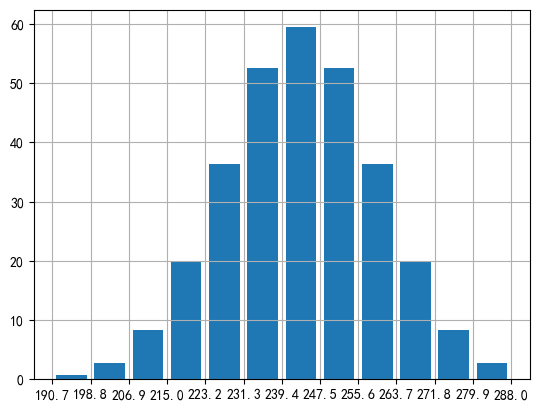

In [10]:
bins_standard=(bins_t-ave_t)/std_t
expe_t = np.diff(norm.cdf(bins_standard))
expe_t=expe_t/expe_t.sum()*count_t
plt.bar(bins_t[:-1]+std_t*0.25,expe_t,width=std_t*0.4)
plt.xticks(np.round(bins_t,1))
plt.grid()
plt.show()

In [11]:
statictic_t,pvalue_t = chisquare(hist_t,expe_t,ddof=2)
print(statictic_t,pvalue_t)

12.363732895541432 0.1935716807031994


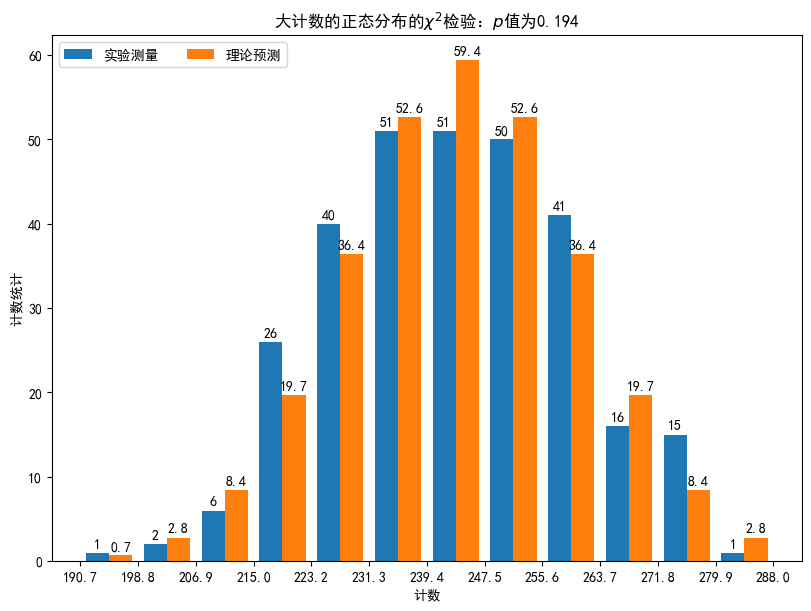

In [17]:
bins_t_int =np.around( np.array(bins_t),1)
species = [bins_t_int[i] for i in range(len(bins_t_int))]
penguin_means = {
    '实验测量': hist_t,
    '理论预测': np.around(expe_t, decimals=1),
}

x = np.arange(len(species)-1)  # the label locations
width = 0.4  # the width of the bars
multiplier = -0.5

fig, ax = plt.subplots(layout='constrained',figsize=(8,6))

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=2)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('计数')
ax.set_ylabel('计数统计')
ax.set_title(fr'大计数的正态分布的$\chi^2$检验：$p$值为{pvalue_t:.3f}')
# ax.set_title(fr'本底计数的Poisson分布的$\chi^2$检验：$p$值为{pvalue_b:.3f}')
ax.set_xticks(np.arange(len(species))-0.5,species)
ax.legend(loc='upper left', ncols=2)

# ax.set_ylim(0, 110)
plt.savefig(path+'normal_chisquare.pdf')
plt.show()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


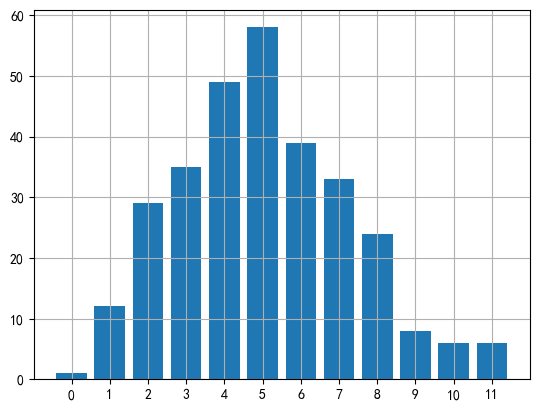

In [13]:
ave_b = N_b.mean()
std_b = N_b.std(ddof=1)
interval_length = int(std_b/2+0.5)

bins_b  = get_bins(N_b,0,interval_length)
print(bins_b)
hist_b, _ = np.histogram(N_b, bins_b)
count_b = hist_b.sum()

plt.bar(bins_b[:-1],hist_b,width=interval_length*0.8)
plt.xticks(bins_b[:-1])
plt.grid()
plt.show()

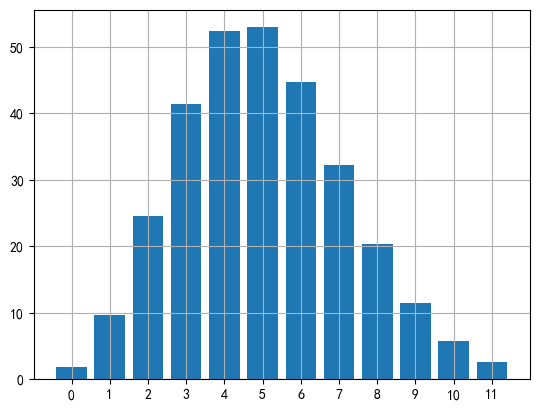

In [14]:
expe_b=poisson.pmf(bins_b[:-1],ave_b)
expe_b = expe_b/expe_b.sum()*count_b
plt.bar(bins_b[:-1],expe_b,width=interval_length*0.8)
plt.xticks(bins_b[:-1])
plt.grid()
plt.show()

In [15]:
statistic_b,pvalue_b = chisquare(hist_b,expe_b,ddof=1)
statistic_b,pvalue_b

(10.045450280509357, 0.4365148670633044)

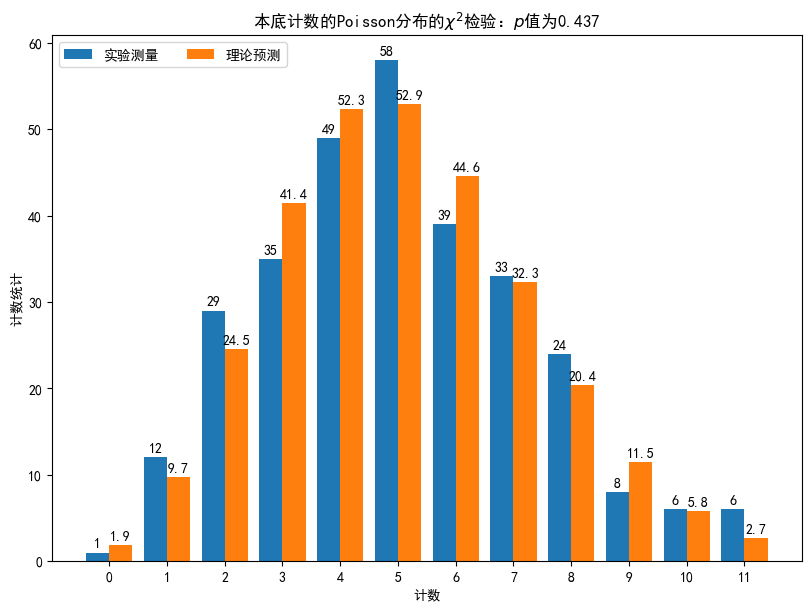

In [18]:
bins_b_int =np.around( np.array(bins_b),1)
species = bins_b[:-1]
penguin_means = {
    '实验测量': hist_b,
    '理论预测': np.around(expe_b, decimals=1),
}

x = np.arange(len(species))  # the label locations
width = 0.4  # the width of the bars
multiplier = 0.5

fig, ax = plt.subplots(layout='constrained',figsize=(8,6))

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=2)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('计数')
ax.set_ylabel('计数统计')
ax.set_title(fr'本底计数的Poisson分布的$\chi^2$检验：$p$值为{pvalue_b:.3f}')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=2)

# ax.set_ylim(0, 150)
plt.savefig(path+'poisson_chisquare.pdf')
plt.show()